In [ ]:
import keras
import numpy
import matplotlib.pyplot as plt
import os
import random
import tensorflow

from keras import backend as K
from keras.datasets import mnist
from keras.engine.topology import Layer
from keras.layers import Activation, Dense, Input, Lambda
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
from keras.utils import plot_model
from PIL import Image
from sklearn.mixture import GaussianMixture
from scipy.stats import mode

numpy.random.seed(42)

# Network parameters
batch_size = 128
num_epochs = 30
kernel_size = 4
latent_dims = [2]
strides = 2
layer_filters = [32, 64]
here = ''

# mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

def preprocess(data):
    if data.ndim == 3:
        data = numpy.asarray([data]).transpose((1, 2, 3, 0))
    maxima = data.max(axis=tuple(range(1, data.ndim))).reshape((len(data),) + (1,) * (data.ndim - 1))
    return data.astype('float32') / maxima, maxima

image_size = x_train.shape[1]
x_train, train_decode = preprocess(x_train)
input_shape = x_train.shape[1:]
num_channels = x_train.shape[-1]
x_test, test_decode = preprocess(x_test)

x_train = numpy.clip(x_train, 0., 1.)
x_test = numpy.clip(x_test, 0., 1.)

def run_tests(model_name):

    encoder_layers = []
    for filters in layer_filters:
        encoder_layers.append(Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   activation='relu',
                   padding='same'))

    decoder_layers = []
    for filters in [num_channels] + layer_filters[:-1]:
        decoder_layers.append(Conv2DTranspose(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   activation='relu',
                   padding='same'))
    decoder_layers[0].activation = Activation('sigmoid')

    # Encoder
    common_input = Input(shape=input_shape, name='encoder_input')
    x = common_input
    for layer in encoder_layers:
        x = layer(x)

    conv_shape = K.int_shape(x)[1:]
    x = Flatten()(x)
    flat_shape = K.int_shape(x)[1:]

    # Latent Layer
    for latent_dim in latent_dims[:-1]:
        layer = Dense(latent_dim, activation='relu')
        x = layer(x)
    layer.activation = Activation(None)

    def sampling(args):
        '''Reparameterization trick by sampling fr an isotropic unit Gaussian.

        # Arguments:
            args (tensor): mean and log of variance of Q(z|X)

        # Returns:
            z (tensor): sampled latent vector
        '''

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    latent_dim = latent_dims[-1]
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that 'output_shape' isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    # z = Dense(latent_dim, name='latent_layer')(x)
    # layer.activation=Activation(None)

    encoder = Model(common_input, [z, z_mean, z_log_var], name='encoder')
    encoder_mean = Model(common_input, z_mean, name='encoder_mean')

    # Decoder
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = decoder_input
    for i, latent_dim in enumerate(latent_dims[-2::-1] + [numpy.prod(encoder_layers[-1].output_shape[1:])]):
        layer = Dense(latent_dim, activation='relu')
        if i == 0:
            layer.activation = Activation(None)
        x = layer(x)
    x = Reshape(conv_shape)(x)

    for layer in decoder_layers[::-1]:
        x = layer(x)
    decoder = Model(decoder_input, x, name='decoder')

    def elbo_loss(yTrue, yPred):
        sample_mean = K.mean(z_mean, 0)
        # large batch size ~> unbiased estimator
        sample_log_var = K.log(K.mean(K.exp(z_log_var), 0))
        kl_loss = K.sum((-z_log_var + K.square(z_mean) + K.exp(z_log_var)) / 2, axis=-1)
        reconstruction_loss = binary_crossentropy(K.flatten(yTrue), K.flatten(yPred)) * numpy.prod(x_train.shape[1:])
        return K.mean(reconstruction_loss) + kl_loss

    def elbo_loss_sample(yTrue, yPred):
        sample_mean = K.mean(z_mean, 0)
        # large batch size ~> unbiased estimator
        sample_log_var = K.log(K.mean(K.exp(z_log_var), 0))
        kl_loss = K.sum((-sample_log_var + K.square(sample_mean) + K.exp(sample_log_var)) / 2, axis=-1)
        reconstruction_loss = binary_crossentropy(K.flatten(yTrue), K.flatten(yPred)) * numpy.prod(x_train.shape[1:])
        return K.mean(reconstruction_loss) + kl_loss

    # Autoencoder
    if model_name == 'variational':
        autoencoder_output = decoder(encoder(common_input)[0])
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss=elbo_loss, optimizer='adam')
        autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)
    elif model_name == 'variational_sample':
        autoencoder_output = decoder(encoder(common_input)[0])
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss=elbo_loss_sample, optimizer='adam')
        autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)
    elif model_name == 'vanilla':
        autoencoder_output = decoder(encoder_mean(common_input))
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
        autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)
    elif model_name == 'double':
        autoencoder_output = decoder(encoder_mean(common_input))
        autoencoder = Model(common_input, autoencoder_output, name='autoencoder')
        autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

        autodecoder_output = encoder_mean(decoder(decoder_input))
        autodecoder = Model(decoder_input, autodecoder_output, name='autodecoder')
        autodecoder.compile(loss='binary_crossentropy', optimizer='adam')
        n = 10
        for _ in range(n):
            train = numpy.random.normal(size=(len(x_train), latent_dims[-1]))
            test = numpy.random.normal(size=(len(x_test), latent_dims[-1]))
            autodecoder.fit(train,
                    train,
                    validation_data=(test, test),
                    epochs=num_epochs // n,
                    batch_size=batch_size)

            autoencoder.fit(x_train,
                    x_train,
                    validation_data=(x_test, x_test),
                    epochs=num_epochs // n,
                    batch_size=batch_size)

    # model_name reconstruction
    autoencoder_output = decoder(encoder_mean(common_input))
    autoencoder_final = Model(common_input, autoencoder_output, name='autoencoder_final')
    autoencoder_final.compile(loss='binary_crossentropy', optimizer='adam')
    x_decoded = autoencoder_final.predict(x_test)
    
    n = 8
    topn = numpy.argsort(((x_decoded - x_test) ** 2).mean((1, 2, 3)))[-n:]
    reversed(topn)
    i1 = x_test[topn]
    i2 = x_decoded[topn]

    if x_test.shape[-1] < 3:
        i1 = numpy.tile(i1, (1,) * (i1.ndim - 1) + (3,))
        i2 = numpy.tile(i2, (1,) * (i2.ndim - 1) + (3,))

    i1 = numpy.concatenate(i1, axis=1)
    i2 = numpy.concatenate(i2, axis=1)

    reconstruction = numpy.concatenate((i1, i2), axis=0)
    
    model_dir = os.path.join(here, model_name)
    os.makedirs(model_dir, exist_ok=True)
    if latent_dims[-1] == 2:
        filename = os.path.join(model_dir, 'digits_over_latent.png')
        # display a 30x30 2D manifold of digits
        n = 30
        digit_size = x_test.shape[1]
        figure = numpy.zeros((digit_size * n, digit_size * n))
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = numpy.linspace(-4, 4, n)
        grid_y = numpy.linspace(-4, 4, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = numpy.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(x_train.shape[1:])
                if digit.ndim == 3:
                    digit = digit.mean(2)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        plt.clf()
        plt.figure(figsize=(10, 10))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range + 1
        pixel_range = numpy.arange(start_range, end_range, digit_size)
        sample_range_x = numpy.round(grid_x, 1)
        sample_range_y = numpy.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel('z[0]')
        plt.ylabel('z[1]')
        plt.imshow(figure, cmap='Greys_r')
        plt.savefig(filename)    
    else:
        filename = None
        
    latent_representation = encoder_mean.predict(x_test)
    labels = frozenset(y_test)
    means = []
    for i in labels:
        means.append(latent_representation[y_test == i].mean(0))
    means = numpy.asarray(means)
    predictions = numpy.argmin(((latent_representation - means[:, numpy.newaxis]) ** 2).sum(2), axis=0)
    plot_model(encoder, to_file=os.path.join(model_dir, 'encoder_{0}.png'.format(str(latent_dims[-1]))), show_shapes=True)
    return reconstruction, filename, (predictions == y_test).mean() * 100

imgs = []
models = ['vanilla', 'double', 'variational', 'variational_sample']
generative_files = []
k_means = []
for model in models:
    reconstruction, generative, k_means_correct = run_tests(model)
    generative_files.append(generative)
    k_means.append(k_means_correct)
    imgs.append(reconstruction)
    
imgs = numpy.concatenate(imgs, axis=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.2666 - val_loss: 0.2305
Epoch 2/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.2243 - val_loss: 0.2189
Epoch 3/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.2160 - val_loss: 0.2134
Epoch 4/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.2121 - val_loss: 0.2101
Epoch 5/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.2098 - val_loss: 0.2083
Epoch 6/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.2083 - val_loss: 0.2073
Epoch 7/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.2071 - val_loss: 0.2064
Epoch 8/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.2060 - val_loss: 0.2047
Epoch 9/30
60000/60000 [==============================] - 5s 78us/step - loss: 0.2050 - val_loss: 0.2036
Epoc

60000/60000 [==============================] - 5s 83us/step - loss: 0.1961 - val_loss: 0.1952
Epoch 3/3
60000/60000 [==============================] - 5s 79us/step - loss: 0.1956 - val_loss: 0.1946
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 76us/step - loss: -6.9979 - val_loss: -7.4841
Epoch 2/3
60000/60000 [==============================] - 5s 78us/step - loss: -7.3634 - val_loss: -5.1993
Epoch 3/3
60000/60000 [==============================] - 5s 75us/step - loss: -6.6580 - val_loss: -7.0223
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 77us/step - loss: 0.2045 - val_loss: 0.1960
Epoch 2/3
60000/60000 [==============================] - 5s 79us/step - loss: 0.1960 - val_loss: 0.1952
Epoch 3/3
60000/60000 [==============================] - 5s 80us/step - loss: 0.1951 - val_loss: 0.1947
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 

60000/60000 [==============================] - 6s 103us/step - loss: 153.1427 - val_loss: 153.1140
Epoch 23/30
60000/60000 [==============================] - 6s 105us/step - loss: 153.0576 - val_loss: 153.4292
Epoch 24/30
60000/60000 [==============================] - 6s 104us/step - loss: 152.9012 - val_loss: 153.2873
Epoch 25/30
60000/60000 [==============================] - 6s 102us/step - loss: 152.8211 - val_loss: 152.9646
Epoch 26/30
 4352/60000 [=>............................] - ETA: 5s - loss: 152.0155

<Figure size 432x288 with 0 Axes>

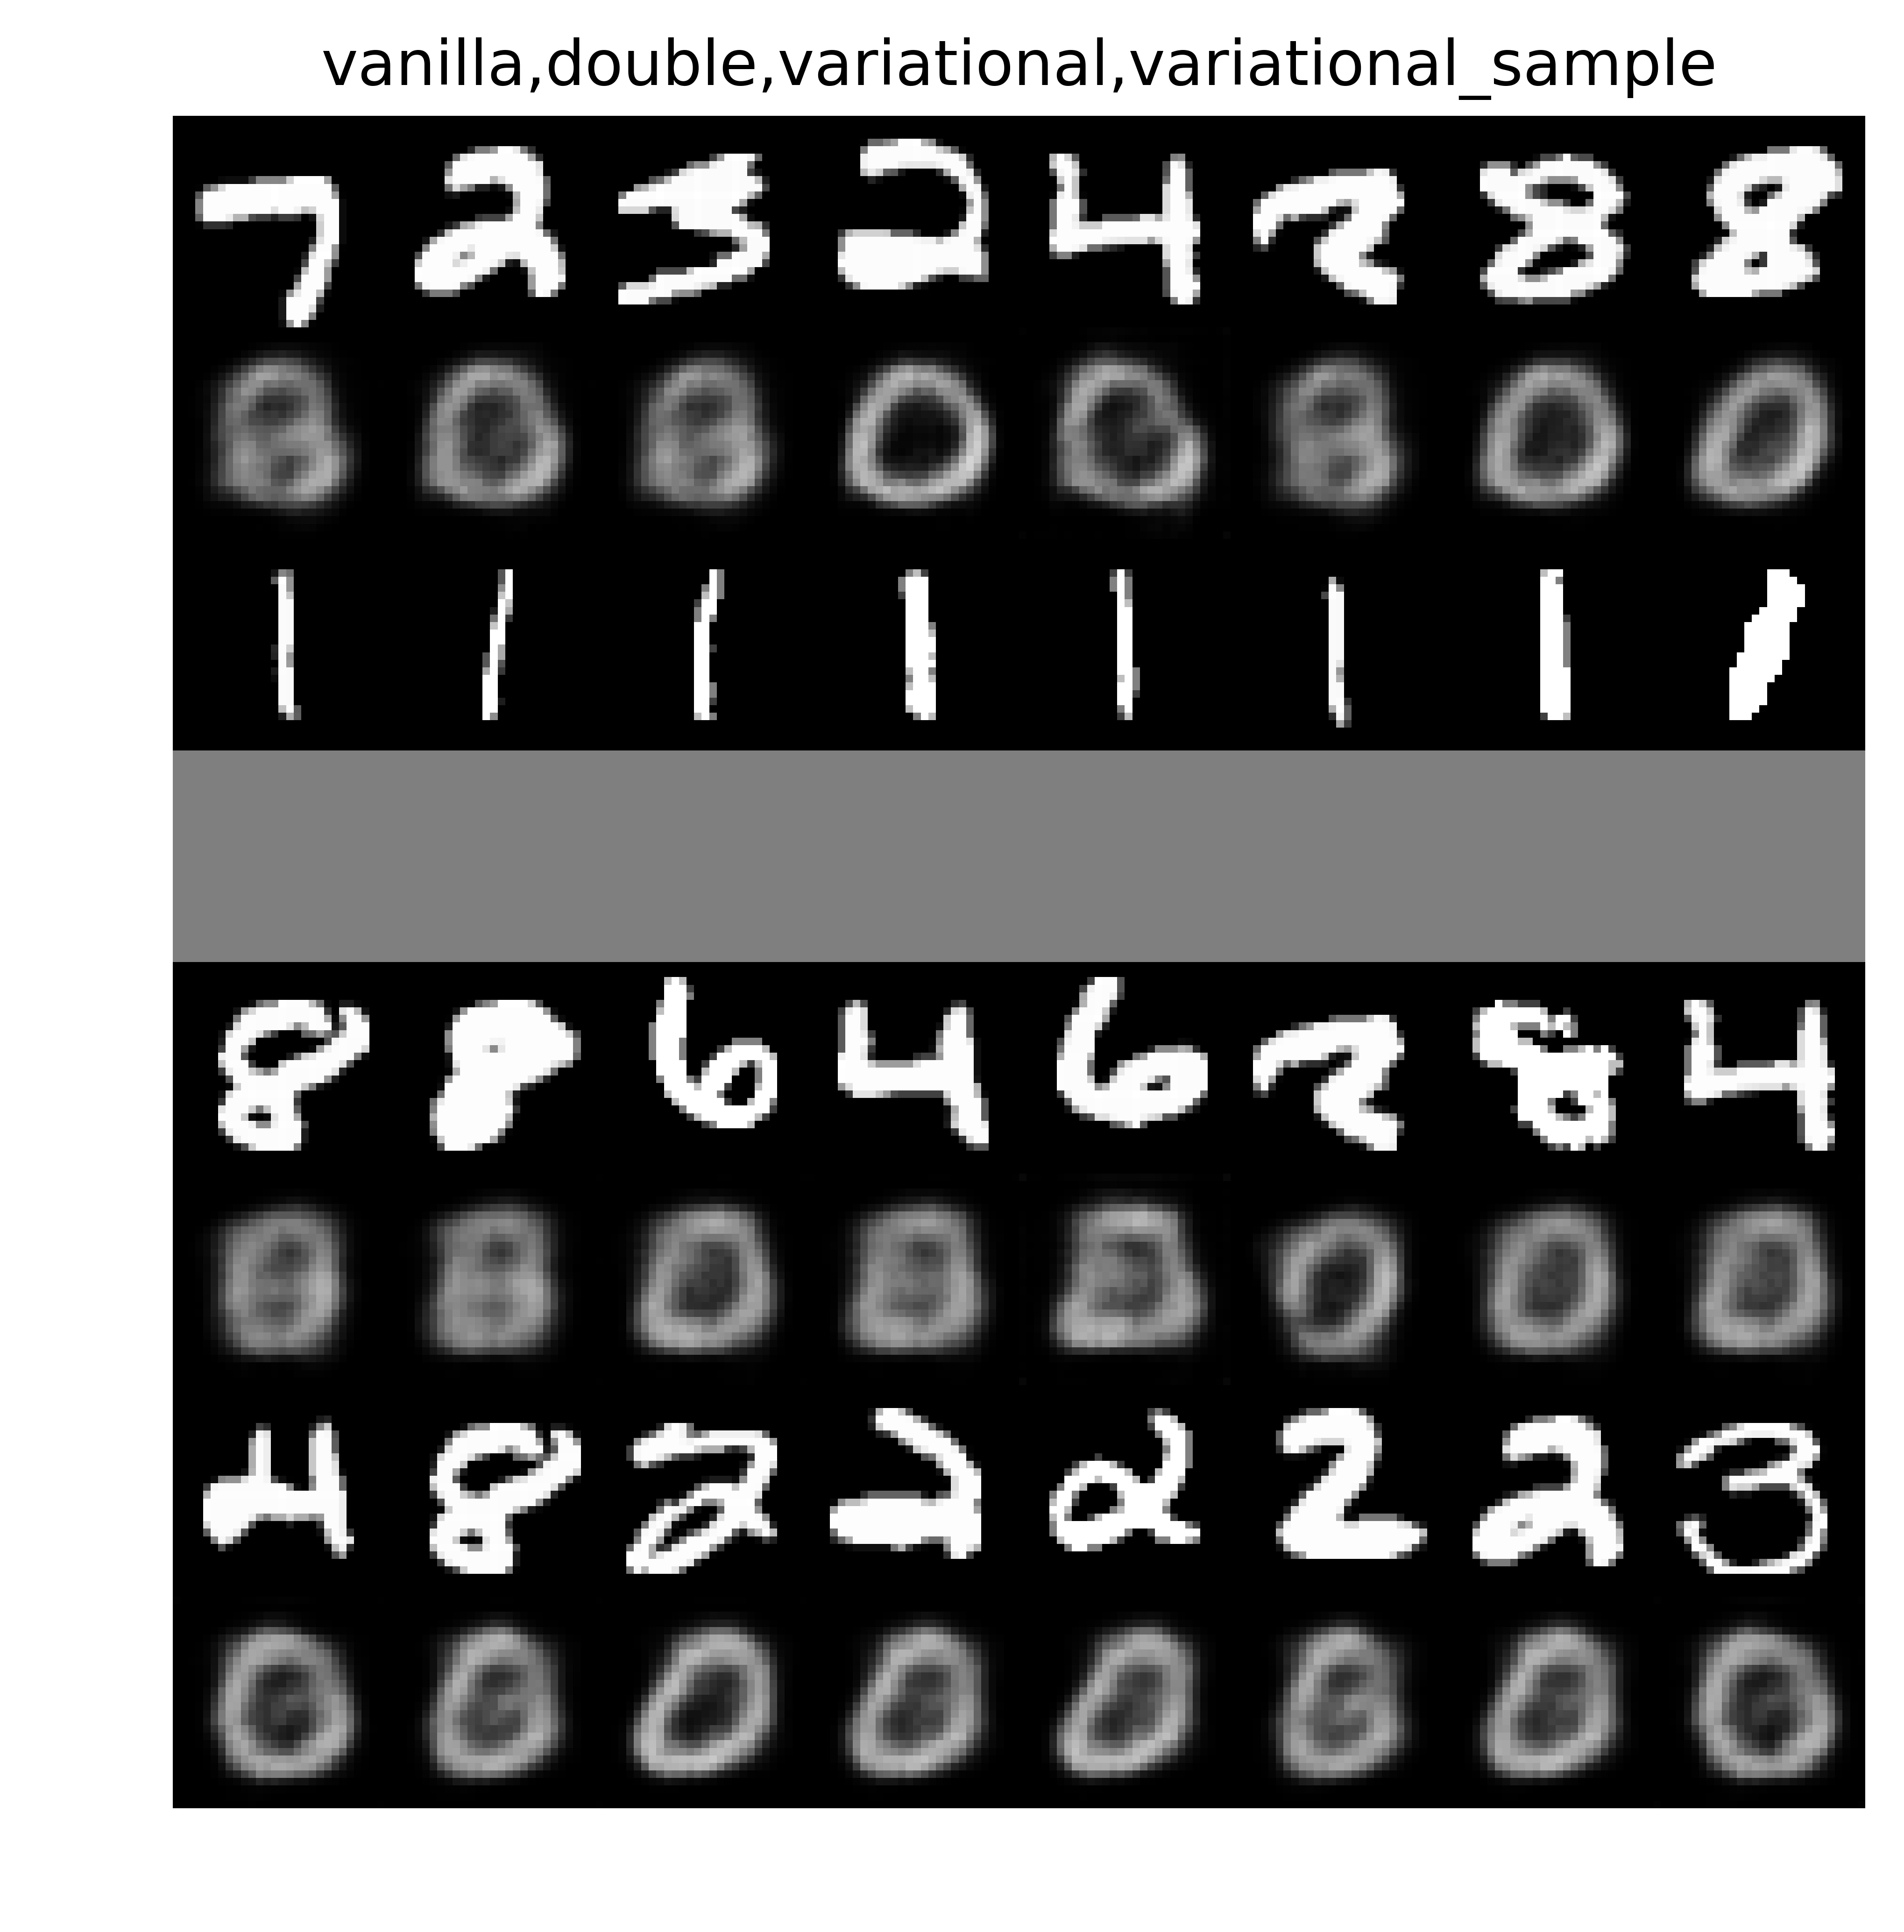

In [4]:
plt.clf()
plt.rcParams['figure.figsize'] = [8, 6]
plt.figure(dpi=800)
plt.title(', '.join(models))
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.axis('off')
plt.savefig('regenerated_{0}.png'.format(latent_dims[-1]))

<Figure size 576x432 with 0 Axes>

<Figure size 6400x4800 with 0 Axes>

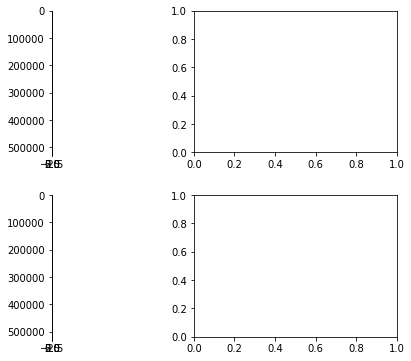

In [5]:
plt.clf()
plt.rcParams['figure.figsize'] = [8, 6]
plt.figure(dpi=800)
f, axarr = plt.subplots(2, 2)
for i, model_name in enumerate(models):
    filename = os.path.join(here, model_name, 'digits_over_latent.png')
    im_frame = Image.open(filename)
    np_frame = numpy.array(im_frame.getdata())
    axarr[i % 2, i % 1].imshow(np_frame)
    
f.subplots_adjust(hspace=0.3)
plt.show()

In [6]:
k_means

[42.1, 25.86, 31.830000000000002, 37.03]